In [1]:
from diffusers import StableDiffusionPipeline, StableDiffusion3Pipeline
from transformers import T5EncoderModel, BitsAndBytesConfig
from huggingface_hub import login
from dotenv import load_dotenv
from IPython.display import display, Image
import matplotlib.pyplot as plt
import torch
import gc
import os
import re

# Path to the .env.hf file
env_hf_path = ".env.hf"

# Check if the .env.hf file exists
if not os.path.exists(env_hf_path):
    # Create the .env.hf file and add an example token
    with open(env_hf_path, "w") as f:
        f.write("HUGGINGFACE_TOKEN=your_token_here\n")
    print(
        f"{env_hf_path} file created. Please add your Hugging Face token to this file."
    )

# Load .env.hf file to get the Hugging Face token
load_dotenv(dotenv_path=env_hf_path)

# Clear memory
torch.cuda.empty_cache()
gc.collect()

# Retrieve Hugging Face token from .env.hf file or set it directly here
hf_token = os.getenv("HUGGINGFACE_TOKEN")

if hf_token is None or hf_token == "your_token_here":
    raise ValueError(f"Please set your Hugging Face token in the {env_hf_path} file.")

# Login using your Hugging Face token
login(token=hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/andrew/.cache/huggingface/token
Login successful


In [2]:
# Define the local model path
local_model_path = os.path.join(os.getcwd(), "models")
remote_model_path = "stabilityai/stable-diffusion-3-medium-diffusers"


# define get_diffusion_pipeline function
def get_diffusion_pipeline(model_path):
    pipe = StableDiffusion3Pipeline.from_pretrained(
        model_path,
        text_encoder_3=None,
        tokenizer_3=None,
        torch_dtype=torch.float16,
    )
    return pipe


# Check if the model is already saved locally
if os.path.exists(local_model_path):
    print("Loading model from local directory.")
    # Load the model from the local folder
    pipe = get_diffusion_pipeline(local_model_path)
else:
    print("Downloading model and saving to local directory.")
    # Load the pipeline from the Hugging Face Hub
    pipe = get_diffusion_pipeline(remote_model_path)

    # Save the model to a local folder
    pipe.save_pretrained(local_model_path)


# pipe = pipe.to("cuda")
pipe.enable_model_cpu_offload()

Loading model from local directory.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

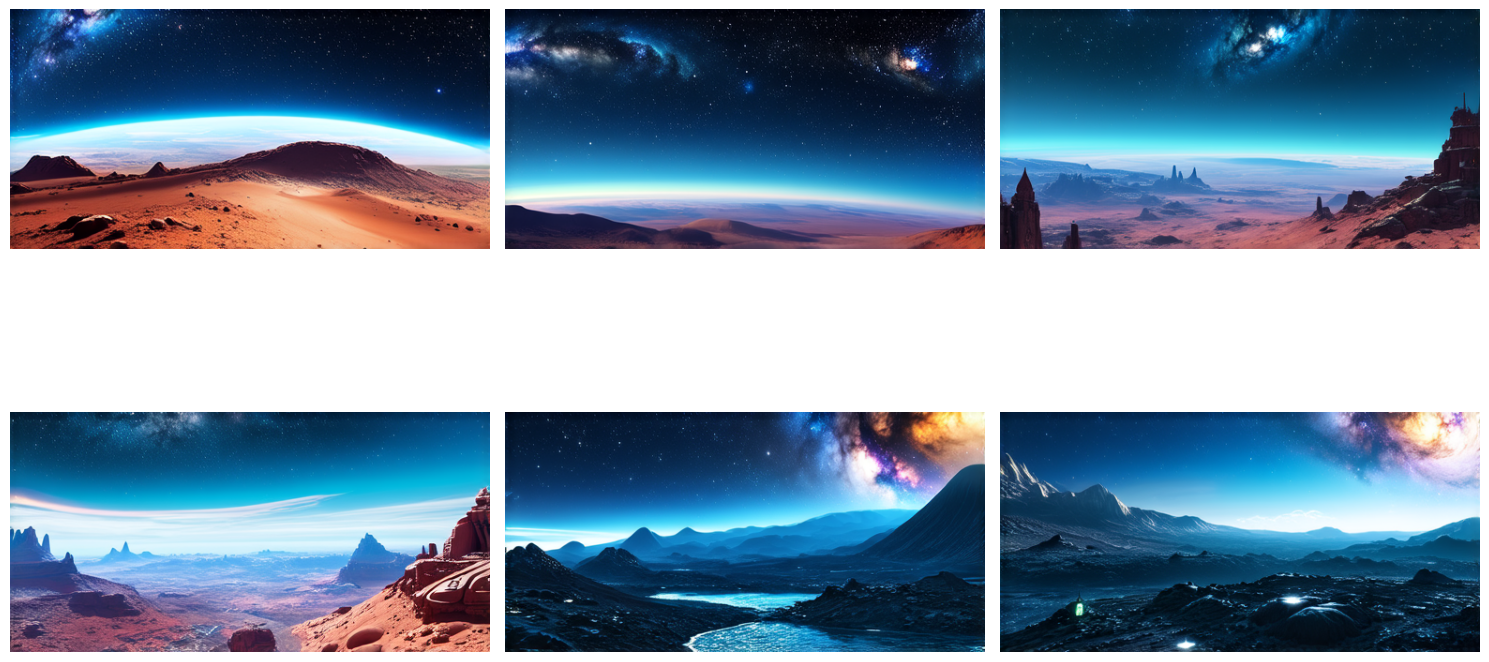

In [3]:
# Settings
seed = 33
prompt = "A beautiful photo of a Sci-fi planetscape landscape! Galaxies and stars are in the sky above the alien planet landscape. Featured on artstation!! High resolution photo!!! HQ"
negative_prompt = "ugly, deformed, disfigured, poor details, bad anatomy, blurry, low-res, low quality"

# All options divisible by 8 (64, 128, 256, 512, 768, 1024, 2048)
height = 256
width = 512
batch_size = 6

generator = torch.Generator("cuda").manual_seed(seed)

# Generate images
images = pipe(
    [prompt] * batch_size,
    negative_prompt=negative_prompt,
    num_inference_steps=28,  # Reduce if necessary
    guidance_scale=7.0,
    generator=generator,
    height=height,  # Reduce if necessary
    width=width,  # Reduce if necessary
).images

# Display images in a grid layout
num_columns = 3
num_rows = (batch_size + num_columns - 1) // num_columns

fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

for i, ax in enumerate(axs.flatten()):
    if i < len(images):
        ax.imshow(images[i])
        ax.axis('off')
    else:
        ax.remove()  # Remove empty subplots

plt.tight_layout()
plt.show()



In [4]:
# Save path for images in folder "output" in current directory
save_path = os.path.join(os.getcwd(), "output")

# Ensure the output directory exists
os.makedirs(save_path, exist_ok=True)

# Function to make filenames friendly
import re

def make_filename_friendly(text):
    # Replace non-alphanumeric characters with underscores
    return re.sub(r'[^\w\s-]', '', text).strip().replace(' ', '_')

# Generate a filename-friendly version of the prompt
friendly_prompt = make_filename_friendly(prompt)

# Save images with custom filenames
for idx, img in enumerate(images):
    # Construct the filename
    filename = f"{seed}_{friendly_prompt}_{idx}.png"
    img.save(os.path.join(save_path, filename))